In [1]:
import sys
sys.path.append('..')

In [2]:
from data import dataset, generate_data
from models import RSSM, MultiRSSM, VCD, adaptation_model
import json
from jax import random
from jax import numpy as jnp
from matplotlib import pyplot as plt
from experiments import evaluation, adaptation
import os
from flax import serialization
import tqdm

In [3]:
# set the number of episodes for adaptation
transfer_data_size = 40

In [4]:
data_conf = json.load(open('../data/image_adapt_conf.json'))
train_data_config = data_conf['train_data_conf']
mixing_function = lambda x: x/255


train_data = dataset.DataLoader(
    generate_data.get_images,
    train_data_config,
    transfer_data_size,
    data_conf["train_data_seed"],
    mixing_function,
)

test_data_config = data_conf['test_data_conf']
test_data = dataset.DataLoader(
    generate_data.get_images,
    test_data_config,
    200,
    data_conf["train_data_seed"],
    mixing_function,
)


In [5]:
rssm_path = '../pretrain/image_rssm'
rssm_chkpt_id = 0
rssm_error, rssm_adapt_state = adaptation.adapt(train_data, test_data, adaptation_model.AdaptRSSM, RSSM.ImageRSSM, rssm_path, rssm_chkpt_id, None, 5000, 50)

vcd_path = '../pretrain/image_vcd'
vcd_chkpt_id = 0
vcd_error, rssm_adapt_state = adaptation.adapt(train_data, test_data, adaptation_model.AdaptVCD, VCD.ImageVCD, vcd_path, vcd_chkpt_id, None, 5000, 50)

training on adaptation data


kl: 1.88, int: 0.00: 100%|██████████| 5000/5000 [1:08:48<00:00,  1.21it/s] 


evaluating


100%|██████████| 100/100 [06:48<00:00,  4.08s/it]


training on adaptation data


kl: 5.31, int: 2.26: 100%|██████████| 5000/5000 [1:19:16<00:00,  1.05it/s] 


evaluating


100%|██████████| 100/100 [06:42<00:00,  4.03s/it]


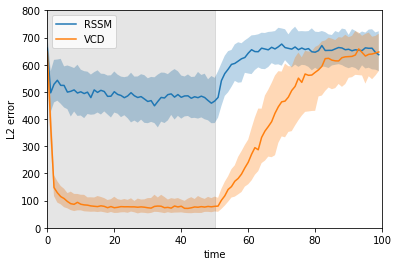

In [8]:
plt.plot(jnp.median(rssm_error, axis=(1,2)), label='RSSM')
plt.fill_between(jnp.arange(100), jnp.quantile(rssm_error, 0.75, axis=(1,2)), jnp.quantile(rssm_error, 0.25, axis=(1,2)), alpha=0.3)
plt.plot(jnp.median(vcd_error, axis=(1,2)), label='VCD')
plt.fill_between(jnp.arange(100), jnp.quantile(vcd_error, 0.75, axis=(1,2)), jnp.quantile(vcd_error, 0.25, axis=(1,2)), alpha=0.3)

plt.fill_betweenx([0,800], [0,0], [50,50], color='k', alpha=0.1)
plt.ylim([0, 800])
plt.xlim([0,100])
plt.xlabel('time')
plt.ylabel('L2 error')
plt.legend()

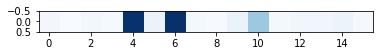

In [9]:
# show identified intervention targets.
plt.imshow(rssm_adapt_state.params['params']['intervention_targets'], cmap='Blues')